In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal,StaticGraphTemporalSignal

from Trainer_loocv import Trainer
from utils_temporal import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

%config InlineBackend.figure_format = 'retina'


In [2]:
df = pd.read_csv('data/final_data_mar.csv.gz')

In [3]:
df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,0.0,18.0,64.0,7.56,13.0,False
2,2014-05-01 02:00:00,1002,116.20531,40.00395,88.0,0.0,18.0,70.0,5.76,13.0,False
3,2014-05-01 03:00:00,1002,116.20531,40.00395,100.0,0.0,17.0,74.0,6.12,13.0,False
4,2014-05-01 04:00:00,1002,116.20531,40.00395,109.0,0.0,17.0,75.0,4.68,1.0,False


In [4]:
df = df[df["station_id"]==1003]
# choose first 20 rows

In [5]:
len(df)

8760

In [6]:
def generate_time_series_graph(df, time_step=1):
    G = nx.Graph()
    for i in range(len(df)):
        G.add_node(i, longitude=df.iloc[i]["longitude"], latitude=df.iloc[i]["latitude"], 
                   humidity=df.iloc[i]["humidity"], temperature=df.iloc[i]["temperature"], wind_speed=df.iloc[i]["wind_speed"],
                   wind_direction=df.iloc[i]["wind_direction"], pm25=df.iloc[i]["PM25_Concentration"])
    n = time_step
    for i in range(len(df) - n):
        current_node = i
        next_nodes = list(range(i+1, i+n+1))
        edges = [(current_node, next_node) for next_node in next_nodes]
        G.add_edges_from(edges)
    return G



In [7]:
G = generate_time_series_graph(df, time_step=4)

In [8]:
# nx.draw(G, with_labels=True, font_weight='bold')

In [9]:
node_features = [[G.nodes[node]['longitude'], G.nodes[node]['latitude'], 
                      G.nodes[node]['temperature'], G.nodes[node]['humidity'], G.nodes[node]['wind_speed'],
                      G.nodes[node]['wind_direction']]
                     for node in G.nodes]
edge_list = [(edge[0], edge[1]) for edge in G.edges]
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor([G.nodes[node]['pm25'] for node in G.nodes], dtype=torch.float).unsqueeze(1)

In [10]:
class GCN_RegressionModel(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 8)
        self.conv2 = GCNConv(8, 256)
        self.linear1 = nn.Linear(256, 256)
        self.linear2 = nn.Linear(256, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [11]:
# first 80% as training data and last 20% as test data
train_mask = torch.tensor([True if i < int(len(G.nodes)*0.8) else False for i in range(len(G.nodes))])
test_mask = torch.tensor([False if i < int(len(G.nodes)*0.8) else True for i in range(len(G.nodes))])

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN_RegressionModel(6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


In [13]:
data = Data(x=x, edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask).to(device)


In [14]:
train_rmse_list = []
test_rmse_list = []
for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%100==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

100%|██████████| 2500/2500 [00:14<00:00, 171.74it/s]


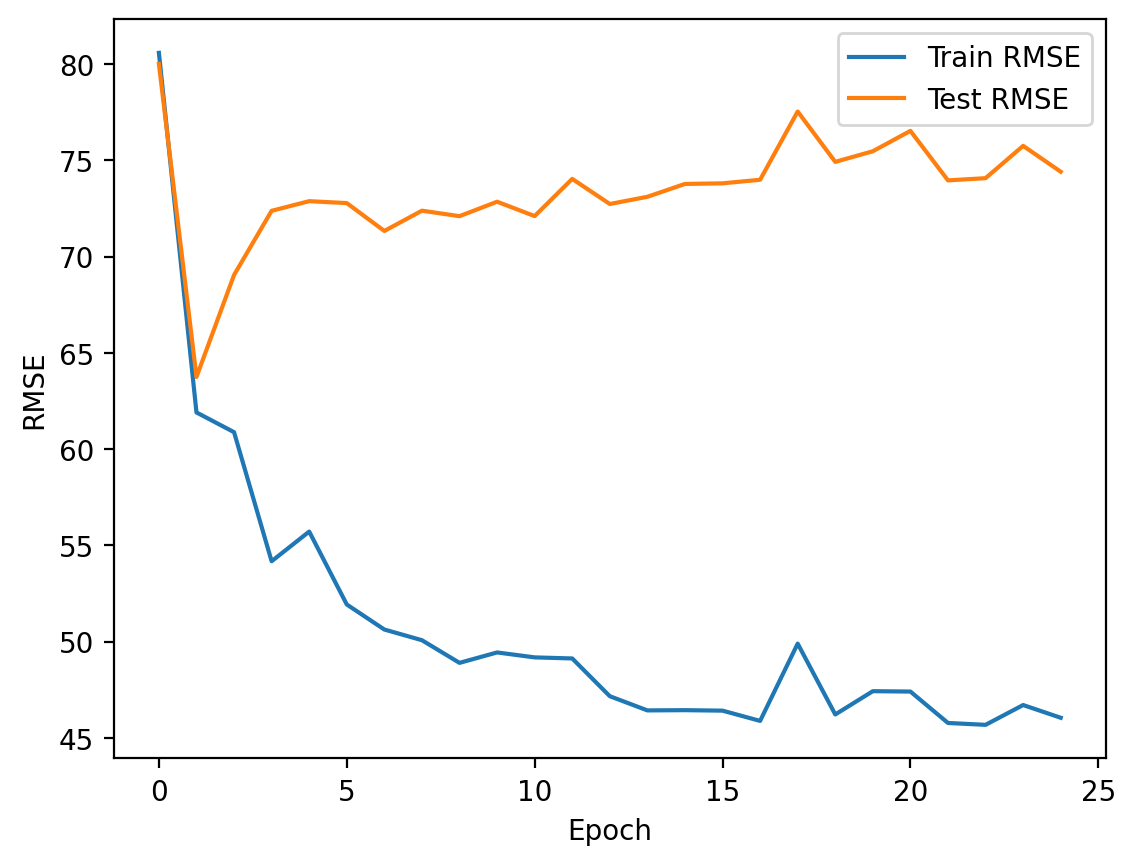

In [15]:
plt.plot(train_rmse_list, label="Train RMSE")
plt.plot(test_rmse_list, label="Test RMSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.show()

In [16]:
out = model(data.x.to(device), data.edge_index.to(device))
out = out[data.test_mask].squeeze().detach().cpu().numpy()


In [17]:
y_real = data.y[data.test_mask].squeeze().detach().cpu().numpy()


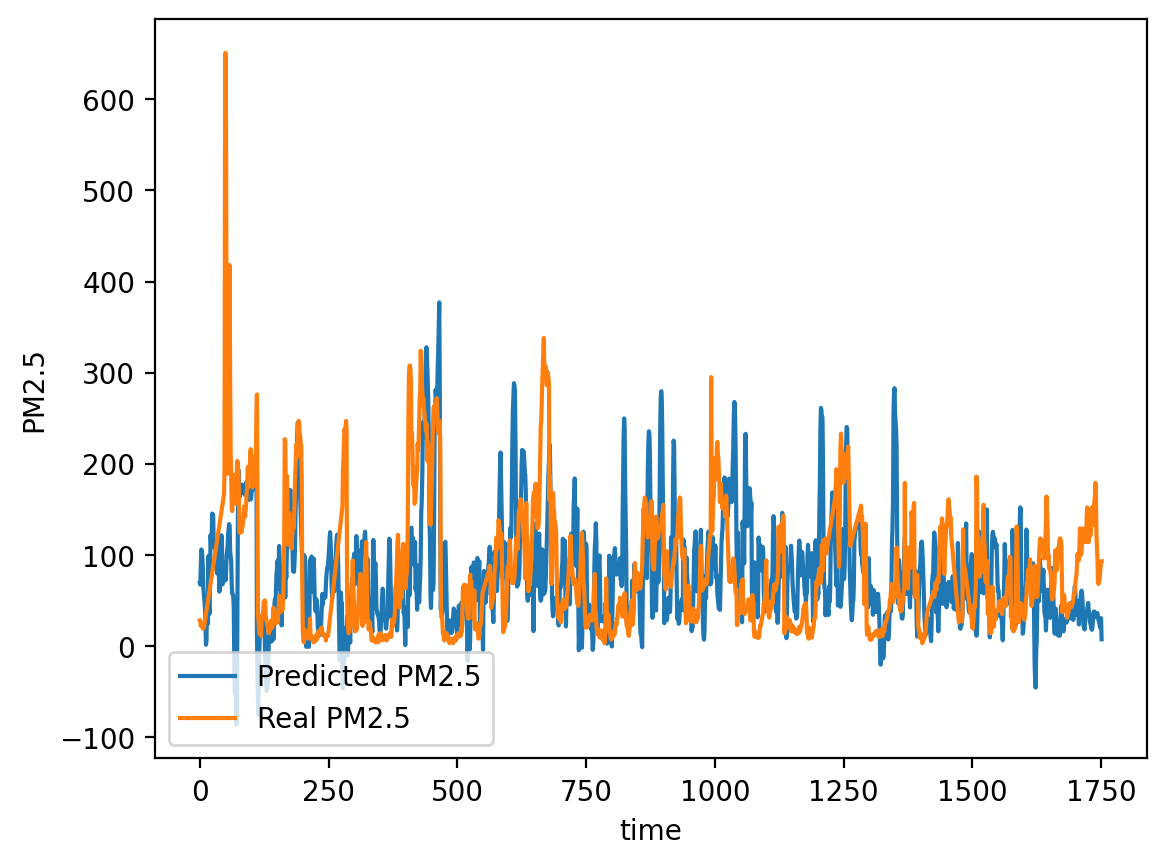

In [18]:
#create different scatter plot for out and y_real
plt.plot(range(len(out)), out, label="Predicted PM2.5")
plt.plot(range(len(y_real)), y_real, label="Real PM2.5")
# location of legend to should be down right
plt.legend(loc='lower left')
plt.xlabel("time")
plt.ylabel("PM2.5")
plt.show()